In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/mc/20230127/test/mc_elg_catalog.fits'))
print(len(cat))

6822127


In [4]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cat['gmag'] = 22.5 - 2.5*np.log10(cat['flux_g'])
    cat['rmag'] = 22.5 - 2.5*np.log10(cat['flux_r'])
    cat['zmag'] = 22.5 - 2.5*np.log10(cat['flux_z'])
    cat['gmagerr'] = 1/np.sqrt(cat['flux_ivar_g'])/cat['flux_g']
    cat['rmagerr'] = 1/np.sqrt(cat['flux_ivar_r'])/cat['flux_r']
    cat['zmagerr'] = 1/np.sqrt(cat['flux_ivar_z'])/cat['flux_z']
    cat['gfibermag'] = 22.5 - 2.5*np.log10(cat['fiberflux_g'])

In [5]:
mask = cat['elglop'].copy()
cat = cat[mask]
print(len(cat))

5378837


In [6]:
nside = 256
hp_in_desi = np.load('/global/cfs/cdirs/desi/users/rongpu/data/imaging_sys/misc/in_desi_healpix_ring.npy', allow_pickle=True).item()[str(nside)]

import healpy as hp
hp_pix = hp.ang2pix(nside, cat['ra'], cat['dec'], nest=False, lonlat=True)

mask = np.in1d(hp_pix, hp_in_desi)
cat = cat[mask]
print(len(cat))

4079298


In [7]:
def detection(cat, nsigma=6.):

    detected = np.full(len(cat), False)
    for band in ['g', 'r', 'z']:
        detected |= cat['flux_'+band] * np.sqrt(cat['flux_ivar_'+band]) > nsigma

    # https://github.com/legacysurvey/legacypipe/blob/fe4fd85c665d808097d8f231269783841ea633bc/py/legacypipe/detection.py#L66-L92
    weights = {'flat': {'g': 1., 'r': 1., 'i': 1., 'z': 1.}, 'red': {'g': 2.5, 'r': 1., 'i': 0.632, 'z': 0.4}}
    for sedname in ['red']:
        stacked_flux, stacked_ivar = np.zeros(len(cat)), np.zeros(len(cat))
        for band in ['g', 'r', 'z']:
            stacked_flux += cat['flux_'+band] * cat['flux_ivar_'+band] / weights[sedname][band]  # inverse variance-weighted stacking
            stacked_ivar +=cat['flux_ivar_'+band] / weights[sedname][band]**2
        stacked_flux /= stacked_ivar
        detected |= stacked_flux * np.sqrt(stacked_ivar) > nsigma

    return detected

In [8]:
dd = detection(cat)
print(np.sum(~dd)/len(dd))

0.0023766344111168145


In [9]:
mask = (cat['gmagerr']<(1/6.)) | (cat['rmagerr']<(1/6.)) | (cat['zmagerr']<(1/6.))
print(1-np.sum(mask)/len(mask))

0.006675903550071638


1.0


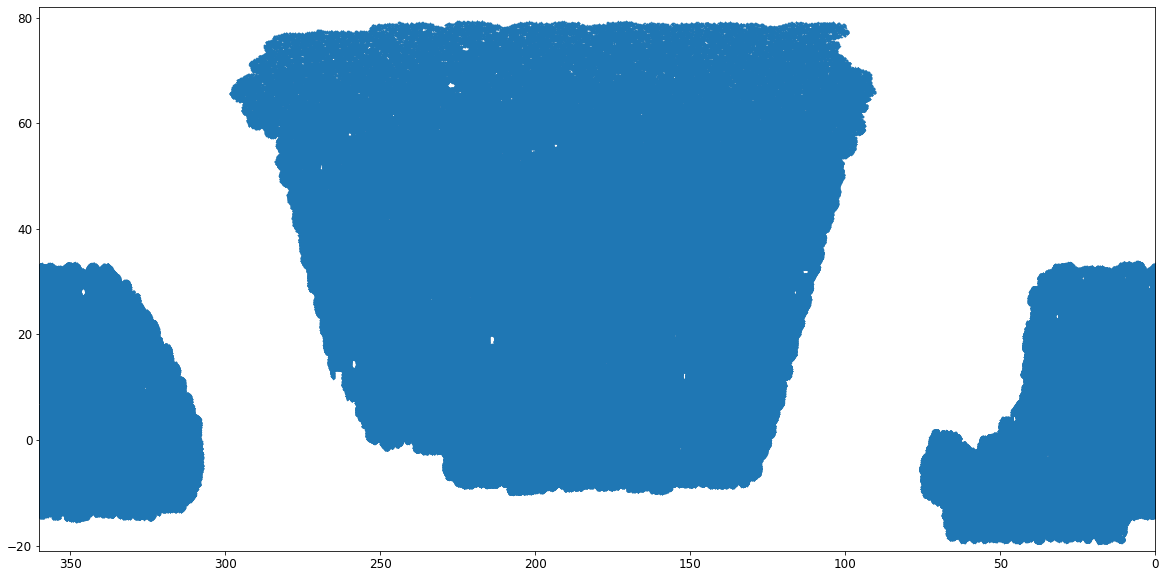

1.0


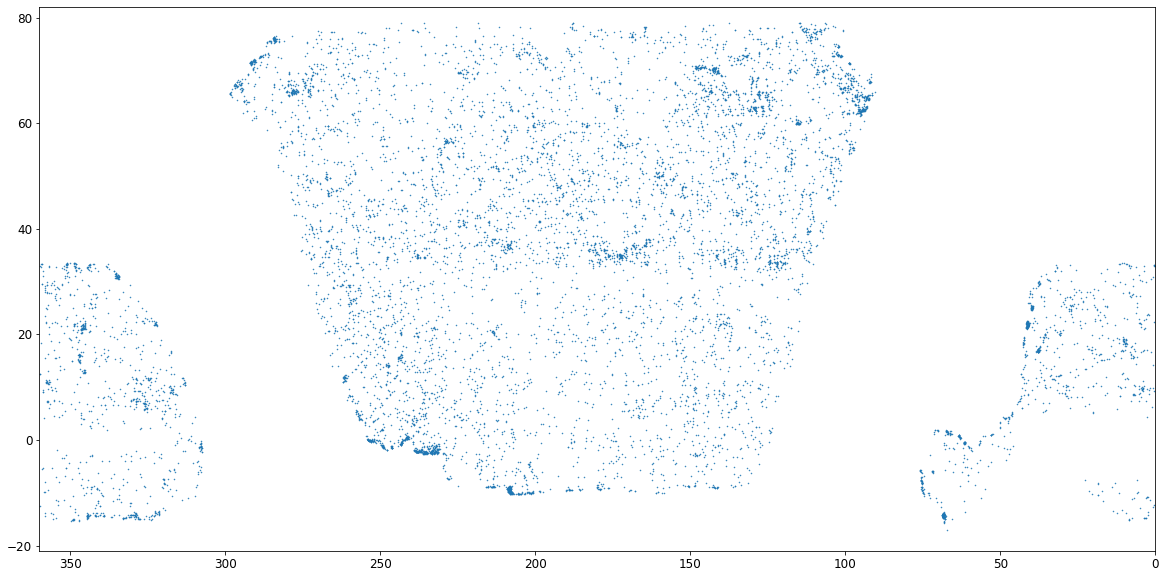

In [11]:
mask = np.full(len(cat), True)
print(np.sum(mask)/np.sum(mask))
plt.figure(figsize=(20, 10))
plt.plot(cat['ra'][mask], cat['dec'][mask], '.', ms=1, alpha=1)
plt.axis([360, 0, -21, 82])
plt.show()

mask = ~dd
print(np.sum(mask)/np.sum(mask))
plt.figure(figsize=(20, 10))
plt.plot(cat['ra'][mask], cat['dec'][mask], '.', ms=1, alpha=1)
plt.axis([360, 0, -21, 82])
plt.show()

In [20]:
mask_north = (cat['dec']>32.375) & (cat['ra']<300) & (cat['ra']>80)
mask_south = ~mask_north

mask0 = mask_north.copy()
mask = mask0 & (~dd)
print('north', np.sum(mask)/np.sum(mask0))

mask0 = mask_south.copy()
mask = mask0 & (~dd)
print('south', np.sum(mask)/np.sum(mask0))

north 0.004010022668806195
south 0.0016496950349032535


The no-detection rate is less than 1% for ELGs.

In [22]:
# Require NOBS_G>=2

mask_north = (cat['dec']>32.375) & (cat['ra']<300) & (cat['ra']>80)
mask_south = ~mask_north

mask0 = mask_north.copy()
mask0 &= (cat['nobs_g']>=2)
mask = mask0 & (~dd)
print('north', np.sum(mask)/np.sum(mask0))

mask0 = mask_south.copy()
mask0 &= (cat['nobs_g']>=2)
mask = mask0 & (~dd)
print('south', np.sum(mask)/np.sum(mask0))

north 0.0025805922084944696
south 0.00022615257565897941


In [25]:
print(1-np.sum(cat['nobs_g']>=2)/len(cat))

0.023300087417001625


1.0


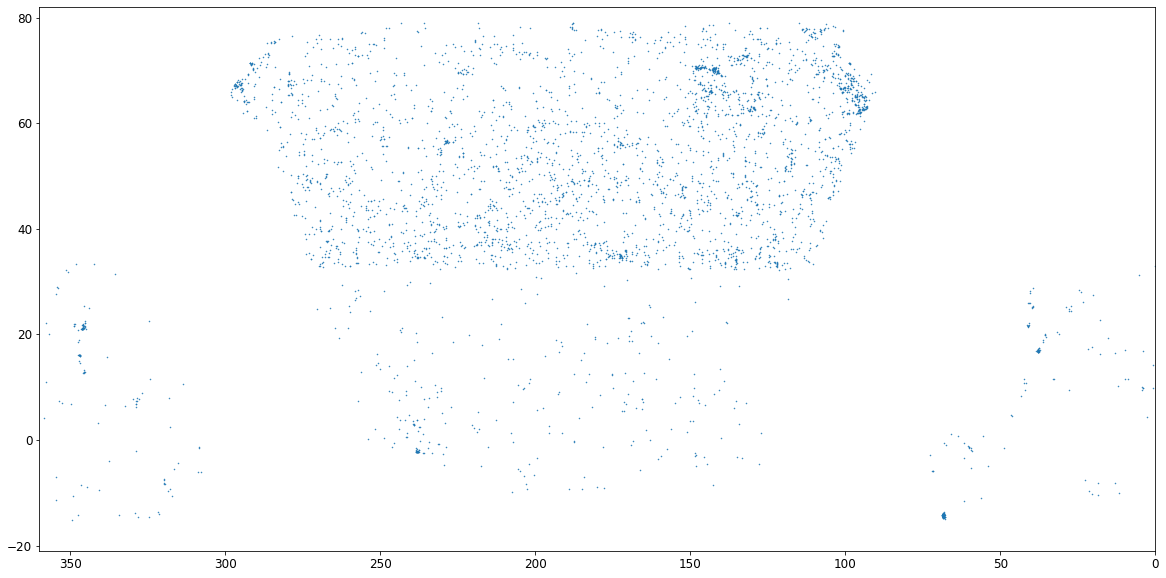

In [23]:
mask = ~dd
mask &= (cat['nobs_g']>=2)
print(np.sum(mask)/np.sum(mask))
plt.figure(figsize=(20, 10))
plt.plot(cat['ra'][mask], cat['dec'][mask], '.', ms=1, alpha=1)
plt.axis([360, 0, -21, 82])
plt.show()